In [ ]:
# Import Pytorch and check the version
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

In [ ]:
# Install extra dependencies 

!pip install pyyaml==5.1
!pip install hiddenlayer

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# Install other opencv dependency to support SIFT
!pip install opencv-contrib-python==4.4.0.44

# After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu111


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
import requests
from io import BytesIO
from itertools import combinations

from google.colab.patches import cv2_imshow
from functools import cmp_to_key

# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# Functions for loading data
def load_data(id):
    imgs = []
    for i in range(5):
        path = f"IMG_{id}_{i+1}"
        if i == 3:
            path += ".png"
        else:
            path += ".tif"
        imgs.append(cv2.imread(path))
    return imgs

def load_saved_data(month):
    imgs = []
    for i in range(5):
        path = f"{month}_{i+1}.png"
        imgs.append(cv2.imread(path))
    return imgs

In [ ]:
# Loading data
jun = load_data("0160")
jul = load_data("0188")
aug = load_data("0067")

In [ ]:
# Functions for aligning images
def align_img(kp_src, ds_src, kp_dst, ds_dst, src_img, feature_matcher, max_matches=100):
    matches = feature_matcher.match(ds_src, ds_dst)
    matches = sorted(matches, key = lambda x:x.distance)
    good_matches = matches[:max_matches]
    good_kp_src = np.empty((len(good_matches),2), dtype=np.float32)
    good_kp_dst = np.empty((len(good_matches),2), dtype=np.float32)
    for i in range(len(good_matches)):
        #-- Get the keypoints from the good matches
        good_kp_src[i,0] = kp_src[good_matches[i].queryIdx].pt[0]
        good_kp_src[i,1] = kp_src[good_matches[i].queryIdx].pt[1]
        good_kp_dst[i,0] = kp_dst[good_matches[i].trainIdx].pt[0]
        good_kp_dst[i,1] = kp_dst[good_matches[i].trainIdx].pt[1]
    h, status = cv2.findHomography(good_kp_src, good_kp_dst, cv2.RANSAC)
    transformed = cv2.warpPerspective(src_img, h, (src_img.shape[1], src_img.shape[0]))
    return transformed

def align_channels(imgs, feature_detector, feature_matcher, selected_channel=3, max_matches=100):
    dst_img = imgs[selected_channel]
    kp_dst, ds_dst = feature_detector.detectAndCompute(dst_img, None)
    aligned_imgs = []
    for i in range(len(imgs)):
        if i == selected_channel:
            aligned_imgs.append(dst_img)
            continue
        src_img = imgs[i]
        kp_src, ds_src = feature_detector.detectAndCompute(src_img, None)
        aligned_img = align_img(kp_src, ds_src, kp_dst, ds_dst, src_img, feature_matcher, max_matches)
        aligned_imgs.append(aligned_img)
    return aligned_imgs

In [ ]:
# Align images 
# Create feature descriptor and matchers
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

jun_aligned = align_channels(jun, sift, bf)
jul_aligned = align_channels(jul, sift, bf)
aug_aligned = align_channels(aug, sift, bf)

In [ ]:
# Load the pre-trained model and create a predictor 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/rpn_R_50_FPN_1x.yaml"))

cfg.DATASETS.TRAIN = ("maize_train",)
cfg.DATASETS.TEST = ("maize_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = 'drive/MyDrive/label_rotated/finetuned-lr=0.005.pth'

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # may need more
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 # faster for testing, use 512 later  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (plot).
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0]]
cfg.MODEL.RPN.NMS_THRESH = 0.3

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1
cfg.MODEL.RPN.NMS_THRESH = 0.3
predictor = DefaultPredictor(cfg)

In [ ]:
# nms helper functions
def nms_thresholding(boxes, score, thresh=0.3):
  assert boxes.shape[0] == score.shape[0]
  
  nms_flag = True
  while(nms_flag):
    counter = 0
    c = list(combinations(np.arange(boxes.shape[0]), 2))
    tbd = set()
    
    for i, j in c:
      if iou(boxes[i], boxes[j]) > thresh:
        counter += 1
        if score[i] > score[j]:
          tbd.add(j)
        else:
          tbd.add(i)
    l = np.ones(score.shape)
    for i in tbd:
      l[i] = 0
    l = l.astype(bool)
    boxes = boxes[l]
    score = score[l]
    if counter == 0:
      nms_flag = False

  return boxes, score

def convert_to_vertices(boxes):
  box_vertices = []
  for box in boxes:
    box_vertices.append([box])

def iou(b1, b2):
  # b1 and b2 are box vertices = [x1, y1, x2, y2]
  if no_intersect(b1, b2):
    return 0
  
  a1, a2 = get_areas(b1, b2)
  [u] = get_union(b1, b2)
  return u/(a1+a2-u)

def no_intersect(b1, b2):
  # compare x axis overlap then compare y axis overlag
  return not (check_overlap(b1[[1,3]], b2[[1,3]]) or check_overlap(b1[[0,2]], b2[[0,2]]))

def get_union(b1, b2):
  union = [max(b1[0], b2[0]),
       max(b1[1], b2[1]),
       min(b1[2], b2[2]),
       min(b1[3], b2[3])]
  return get_areas(union)


def check_overlap(x1_c, x2_c):
  return (x1_c[1] > x2_c[0] > x1_c[0]) or (x1_c[1] > x2_c[1] > x1_c[0]) or (x2_c[1] > x1_c[1] > x2_c[0]) or (x2_c[1] > x1_c[0] > x2_c[0])

def get_areas(*args):
  areas = []
  for arg in args:
     arg = np.array(arg)
     xs, ys = arg[[0,2]], arg[[1,3]]
     areas.append(max(0, (xs[1]-xs[0])*(ys[1]-ys[0])))
  return areas

def predict_boxes(predictor, im):
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    boxes = outputs['proposals'].proposal_boxes.to("cpu")
    bb = boxes.tensor.numpy()
    score = (1 / (1+torch.exp(-outputs['proposals'].objectness_logits))).to("cpu").numpy()
    box = bb[score > 0.9]
    score = score[score > 0.9]
    box, score = nms_thresholding(box, score, thresh=0.25)
    return box

def compute_ndvi(imgs, mask_thresh):
    [b, g, r, re, nir] = imgs
    r, nir = r.astype(float), nir.astype(float)
    mask = re > mask_thresh
    for img in imgs:
        mask = mask * (img > 0)
    mask = mask.astype(float)
    ndvi = (nir - r) / (nir + r)
    ndvi = np.nan_to_num(ndvi, nan=0)
    ndvi[(nir + r) == 0] = 0
    boxes = predict_boxes(predictor, re)
    indices = []
    for box in boxes:
        [left, top, right, bottom] = box
        left, top, right, bottom = int(left), int(top), int(right), int(bottom)
        plot = ndvi[top: bottom, left: right]
        plot_mask = mask[top: bottom, left: right]
        score = np.mean(plot[plot_mask > 0])
        if np.isnan(score):
            score = 0
        indices.append(score)
    return boxes, indices


In [ ]:
# Compute NDVI
jun_box, jun_ndvi = compute_ndvi(jun_aligned, 140)
jul_box, jul_ndvi = compute_ndvi(jul_aligned, 130)
aug_box, aug_ndvi = compute_ndvi(aug_aligned, 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Function for visualization
def compare(p1, p2):
    if p1[0][0] - p2[0][0] < -150:
        return -1
    elif p1[0][0] - p2[0][0] > 150:
        return 1
    elif p1[0][1] < p2[0][1]:
        return -1
    elif p1[0][1] > p2[0][1]:
        return 1
    else:
        return 0

def visualize(imgs, boxes, scores):
    [b, g, r, re, nir] = imgs
    out_img = np.zeros_like(imgs[0])
    out_img[:, :, 0] = r[:, :, 0]
    out_img[:, :, 1] = g[:, :, 1]
    out_img[:, :, 2] = b[:, :, 2]
    pairs = [(boxes[i], scores[i]) for i in range(len(boxes))]
    pairs = sorted(pairs, key=cmp_to_key(compare))
    boxes = [p[0] for p in pairs]
    scores = [p[1] for p in pairs]
    colors = ['gold', 'blue']*(len(boxes)//2+1)
    v = Visualizer(out_img[:, :, ::-1], scale=0.5)
    scores = [str(round(s, 3)) for s in scores]
    out = v.overlay_instances(boxes=boxes, labels=scores, assigned_colors=colors, alpha=0.8)
    result = out.get_image()[:, :, ::-1]
    cv2_imshow(result)
    return result

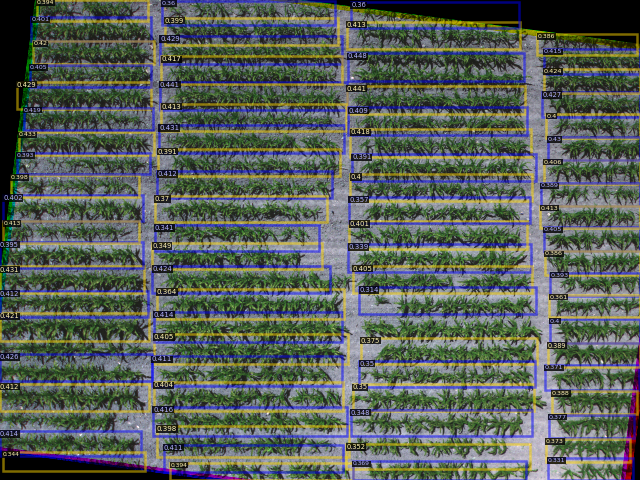

True

In [ ]:
jun_result = visualize(jun_aligned, jun_box, jun_ndvi)
cv2.imwrite("/content/jun_ndvi.png", jun_result)

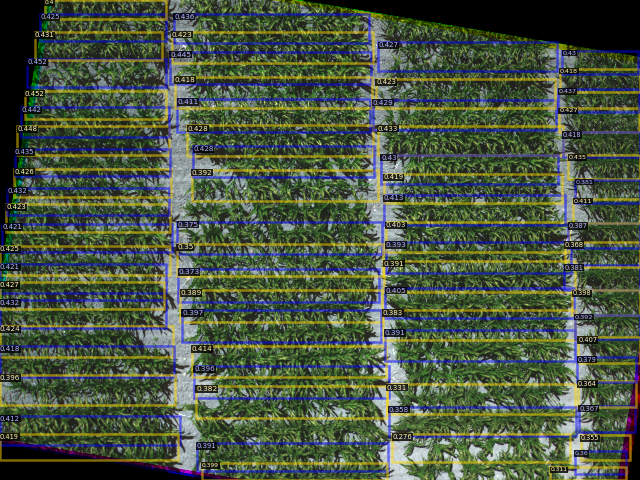

True

In [ ]:
jul_result = visualize(jul_aligned, jul_box, jul_ndvi)
cv2.imwrite("/content/jul_ndvi.png", jul_result)

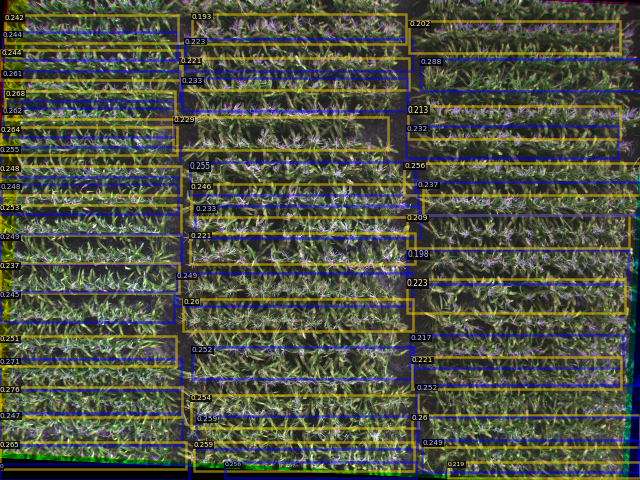

In [ ]:
aug_result = visualize(aug_aligned, aug_box, aug_ndvi)
#cv2.imwrite("/content/aug_ndvi.png", aug_result)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


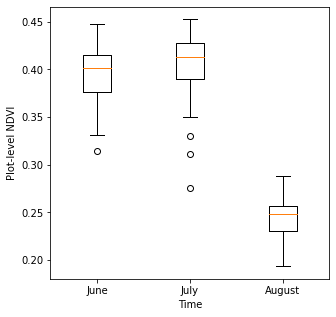

In [ ]:
# Boxplot
plt.figure(figsize=(5,5))
plt.boxplot([jun_ndvi, jul_ndvi, aug_ndvi])
plt.xticks([1, 2, 3], ['June', 'July', 'August'])
plt.xlabel("Time")
plt.ylabel("Plot-level NDVI")
plt.savefig("ndvi_boxplot.png")